<a href="https://colab.research.google.com/github/delte1821/ML-SERS/blob/master/ML_SERS_v2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
!pip install xgboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.1/297.1 MB 881.8 kB/s eta 0:00:00


In [74]:
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, BatchNormalization, Dropout, Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler, LabelEncoder, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
from matplotlib import rcParams
import tensorflow as tf
from scipy import stats
import xgboost as xgb

rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['DejaVu Sans']

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
def initialize_paths(file_path):
    figure_path = os.path.join(file_path, "Figures")
    if not os.path.exists(figure_path):
        os.makedirs(figure_path)
    return figure_path

In [8]:
def load_data(file_path):
    df = pd.read_excel(file_path, header=None)
    materials = df.iloc[0, :].astype(int)  # Ensure materials are integers
    concentrations = df.iloc[1, :].astype(float)
    data = df.iloc[2:, :].values
    return data, materials, concentrations

In [9]:
def filter_by_material(data, materials, concentrations, material_type):
    indices = materials == material_type
    filtered_data = data[:, indices]
    filtered_concentrations = concentrations[indices]

    # Add peak information by averaging data for 603-613 and 852-862
    if material_type == 1:
        peak_data = np.mean(data[603:614, indices], axis=0)  # 603-613 (inclusive) -> 603:614 (0-indexed)
    elif material_type == 2:
        peak_data = np.mean(data[852:863, indices], axis=0)  # 852-862 (inclusive) -> 852:863 (0-indexed)
    else:
        peak_data = np.zeros(indices.sum())

    # Add the peak data as a new row to the filtered data
    filtered_data_with_peaks = np.vstack((filtered_data, peak_data))

    return filtered_data_with_peaks, filtered_concentrations

In [10]:
def preprocess_data(data):
    nsamples, nx, ny = data.shape
    data_2d = data.reshape((nsamples, nx * ny))
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data_2d)
    data_reshaped = data_scaled.reshape(nsamples, nx, ny)
    return data_reshaped

In [27]:
def augment_data(data, labels, num_augmented_samples):
    augmented_data = []
    augmented_labels = []
    original_len = len(data)
    for sample, label in zip(data, labels):
        augmented_data.append(sample)
        augmented_labels.append(label)
        for _ in range(num_augmented_samples):
            noise = np.random.normal(0, 0.05, sample.shape)
            augmented_sample = sample + noise

            # Additional augmentations
            scale_factor = np.random.uniform(0.95, 1.05)
            augmented_sample = augmented_sample * scale_factor

            shift_value = np.random.uniform(-0.05, 0.05, sample.shape)
            augmented_sample = augmented_sample + shift_value

            augmented_data.append(augmented_sample)
            augmented_labels.append(label)
    augmented_data = np.array(augmented_data)
    augmented_labels = np.array(augmented_labels)
    print(f"Original data size: {original_len}, Augmented data size: {len(augmented_data)}")
    return augmented_data, augmented_labels

In [45]:
def build_cnn_model(input_shape):
    model = Sequential([
        Conv1D(16, kernel_size=3, activation='relu', input_shape=input_shape, kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        MaxPooling1D(2),
        Conv1D(32, kernel_size=3, activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        MaxPooling1D(2),
        Flatten(),
        Dense(50, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.5),
        Dense(1, kernel_regularizer=l2(0.01))  # Output layer for concentration prediction
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model


In [47]:
def build_nn_model(input_shape):
    model = Sequential([
        Dense(64, activation='relu', input_shape=input_shape),
        Dense(32, activation='relu'),
        Dense(1)  # Output layer for regression
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [72]:
def train_nn_regression(X_train, y_train, X_val, y_val, epochs=100, batch_size=32, use_early_stopping=True):
    model = build_nn_model((X_train.shape[1],))

    # Early stopping callback
    callbacks = [EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)] if use_early_stopping else []

    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), callbacks=callbacks)
    y_pred = model.predict(X_val)
    mse = mean_squared_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    return model, mse, r2, history

In [70]:
def train_and_validate(data, materials, concentrations, material_types, display=True, figure_path=None, epochs=200, batch_size=128, num_augmented_samples=100, use_early_stopping=True):
    results = {}
    fig_counter = 1

    for mat_type in material_types:
        X, y = filter_by_material(data, materials, concentrations, mat_type)

        # Check sizes before processing
        print(f"Original X shape: {X.shape}, Original y shape: {y.shape}")

        # Ensure X and y have consistent length
        assert X.shape[1] == len(y), "Inconsistent number of samples between data and labels"

        X_train, X_val, y_train, y_val = train_test_split(X.T, y, test_size=0.2, random_state=42)
        X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
        X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)

        # Data augmentation
        X_train, y_train = augment_data(X_train, y_train, num_augmented_samples)

        X_train = preprocess_data(X_train)
        X_val = preprocess_data(X_val)

        # Reshape back to 2D for regression models
        X_train_2d = X_train.reshape(X_train.shape[0], -1)
        X_val_2d = X_val.reshape(X_val.shape[0], -1)

        # Define and train multiple regression models
        models = {
            'Ridge': Ridge(alpha=1.0),
            'Lasso': Lasso(alpha=1.0),
            'ElasticNet': ElasticNet(alpha=1.0, l1_ratio=0.5),
            'XGBoost': xgb.XGBRegressor(objective='reg:squarederror'),
            'NeuralNetwork': None  # Will be created separately
        }

        best_model = None
        best_r2 = -np.inf
        best_name = ""

        for name, model in models.items():
            if name == 'NeuralNetwork':
                model, mse, r2, history = train_nn_regression(X_train_2d, y_train, X_val_2d, y_val, epochs=epochs, batch_size=batch_size, use_early_stopping=use_early_stopping)
            else:
                model.fit(X_train_2d, y_train)
                y_pred = model.predict(X_val_2d)
                mse = mean_squared_error(y_val, y_pred)
                r2 = r2_score(y_val, y_pred)

            print(f"{name} Regression MSE: {mse}, R2: {r2}")

            if r2 > best_r2:
                best_r2 = r2
                best_model = model
                best_name = name

        print(f"Best model: {best_name} with R2: {best_r2}")
        results[mat_type] = (best_model, best_r2)

        # Save the best model's predictions and plots
        if display:
            y_pred = best_model.predict(X_val_2d) if best_name != 'NeuralNetwork' else best_model.predict(X_val_2d).flatten()
            plot_predictions(y_val, y_pred, mat_type, fig_counter, figure_path)
            if best_name == 'NeuralNetwork':
                plot_training_history(history, mat_type, fig_counter, figure_path)

        fig_counter += 1
    return results

In [60]:
def plot_predictions(y_true, y_pred, material_type, fig_counter, figure_path):
    material_name = "IL6" if material_type == 1 else "TNF" if material_type == 2 else "Control"
    fig_filename = os.path.join(figure_path, f'{material_name}_LR_{fig_counter}.png')
    # Check if file exists and increment counter if necessary
    while os.path.exists(fig_filename):
        fig_counter += 1
        fig_filename = os.path.join(figure_path, f'{material_name}_LR_{fig_counter}.png')

    plt.figure(figsize=(8, 6))
    plt.scatter(y_true, y_pred, c='blue')
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--')
    plt.xlabel('Actual Concentrations')
    plt.ylabel('Predicted Concentrations')
    plt.title(f'Actual vs Predicted Concentrations for {material_name}')
    r2 = r2_score(y_true, y_pred)
    plt.text(0.05, 0.95, f'R² = {r2:.2f}', transform=plt.gca().transAxes, fontsize=14, verticalalignment='top')
    plt.tight_layout()
    plt.savefig(fig_filename)
    plt.show()

In [61]:
def plot_training_history(history, material_type, fig_counter, figure_path):
    material_name = "IL6" if material_type == 1 else "TNF" if material_type == 2 else "Control"
    fig_filename = os.path.join(figure_path, f'{material_name}_TH_{fig_counter}.png')
    # Check if file exists and increment counter if necessary
    while os.path.exists(fig_filename):
        fig_counter += 1
        fig_filename = os.path.join(figure_path, f'{material_name}_TH_{fig_counter}.png')

    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Epoch vs Loss for {material_name}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(fig_filename)
    plt.show()

In [78]:
def classify_materials(data, materials, display=True, figure_path=None, validation_size=0.2, num_augmented_samples=20):
    data = data.T

    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)

    pca = PCA(n_components=2)
    data_pca = pca.fit_transform(data_scaled)

    assert data_pca.shape[0] == len(materials), "Inconsistent number of samples between data and materials"

    X_train, X_val, y_train, y_val = train_test_split(data_pca, materials, test_size=validation_size, random_state=42)

    # Data augmentation for classification
    X_train, y_train = augment_data(X_train, y_train, num_augmented_samples)

    # Encode labels
    le = LabelEncoder()
    y_train_encoded = le.fit_transform(y_train)
    y_val_encoded = le.transform(y_val)

    # Compute class weights
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train_encoded), y=y_train_encoded)
    class_weights_dict = dict(enumerate(class_weights))

    # Train RandomForest Classifier with class weights
    clf = RandomForestClassifier(random_state=42, class_weight='balanced', n_estimators=100)
    clf.fit(X_train, y_train_encoded)
    y_pred = clf.predict(X_val)

    # Decode labels
    y_pred_decoded = le.inverse_transform(y_pred)

    # Convert integer labels to strings for classification_report
    target_names = [str(label) for label in le.classes_]

    # Print classification report
    print("Material Classification Report (Validation):")
    print(classification_report(y_val_encoded, y_pred, target_names=target_names))

    # Plot confusion matrix
    if display:
        plot_confusion_matrix(y_val_encoded, y_pred, target_names, figure_path)

    # Calculate and print specificity and sensitivity
    cm = confusion_matrix(y_val_encoded, y_pred)
    specificity, sensitivity = calculate_specificity_sensitivity(cm)

    # Save the sensitivity and specificity to a file
    fig_counter = 1
    results_file_path = os.path.join(figure_path, f'Sensitivity_Specificity_{fig_counter}.txt')
    while os.path.exists(results_file_path):
        fig_counter += 1
        results_file_path = os.path.join(figure_path, f'Sensitivity_Specificity_{fig_counter}.txt')
    with open(results_file_path, 'w') as f:
        for i, material in enumerate(target_names):
            f.write(f"Material: {material}\n")
            f.write(f"Specificity: {specificity[i]:.2f}\n")
            f.write(f"Sensitivity: {sensitivity[i]:.2f}\n")
            f.write("\n")

    # Also print the sensitivity and specificity to the console
    for i, material in enumerate(target_names):
        print(f"Material: {material}")
        print(f"Specificity: {specificity[i]:.2f}")
        print(f"Sensitivity: {sensitivity[i]:.2f}")
        print()

In [76]:
def calculate_specificity_sensitivity(cm):
    """
    Calculate the specificity and sensitivity for each class given a confusion matrix.

    Args:
    - cm: Confusion matrix (numpy array).

    Returns:
    - specificity: List of specificity values for each class.
    - sensitivity: List of sensitivity values for each class.
    """
    specificity = []
    sensitivity = []
    for i in range(len(cm)):
        tn = np.sum(np.delete(np.delete(cm, i, axis=0), i, axis=1))  # True Negatives
        fp = np.sum(np.delete(cm[:, i], i))  # False Positives
        fn = np.sum(np.delete(cm[i, :], i))  # False Negatives
        tp = cm[i, i]  # True Positives

        specificity.append(tn / (tn + fp))
        sensitivity.append(tp / (tp + fn))
    return specificity, sensitivity

In [64]:
def plot_confusion_matrix(y_true, y_pred, labels, figure_path, fig_counter=1):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    fig_filename = os.path.join(figure_path, f'CM_{fig_counter}.png')
    # Check if file exists and increment counter if necessary
    while os.path.exists(fig_filename):
        fig_counter += 1
        fig_filename = os.path.join(figure_path, f'CM_{fig_counter}.png')

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    disp.plot(cmap=plt.cm.Blues, values_format='d')
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.savefig(fig_filename)
    print(f'Confusion matrix saved{fig_filename}')
    plt.show()
    plt.close()


In [68]:
# Paths and instantiation
file_path = "/content/drive/My Drive/Colab Notebooks/Spectra/Low"  # Update to your actual path in Google Drive
figure_path = initialize_paths(file_path)
original_file_path = os.path.join(file_path, "Combine.xlsx")
display = True
epochs = 200
batch_size = 32
num_augmented_samples=20
use_early_stopping = True

# Load and preprocess data
data, materials, concentrations = load_data(original_file_path)
material_types = [1, 2]  # Focusing on IL6 and TNF for example

Original X shape: (1025, 124), Original y shape: (124,)
Original data size: 99, Augmented data size: 2079
Ridge Regression MSE: 1264.1295099293625, R2: -0.5017238474135961
Lasso Regression MSE: 552.0961062548121, R2: 0.34413690819276055


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.636e+03, tolerance: 2.012e+02
  model = cd_fast.enet_coordinate_descent(


ElasticNet Regression MSE: 551.3239092540629, R2: 0.3450542403504374
XGBoost Regression MSE: 921.2697815493467, R2: -0.09442330867782323
Epoch 1/200
65/65 [==============================] - 1s 5ms/step - loss: 982.2086 - val_loss: 598.0615
Epoch 2/200
65/65 [==============================] - 0s 3ms/step - loss: 738.5532 - val_loss: 466.3560
Epoch 3/200
65/65 [==============================] - 0s 3ms/step - loss: 634.0294 - val_loss: 389.0753
Epoch 4/200
65/65 [==============================] - 0s 3ms/step - loss: 576.8821 - val_loss: 442.2292
Epoch 5/200
65/65 [==============================] - 0s 3ms/step - loss: 499.5764 - val_loss: 412.8923
Epoch 6/200
65/65 [==============================] - 0s 3ms/step - loss: 440.2404 - val_loss: 423.7471
Epoch 7/200
65/65 [==============================] - 0s 3ms/step - loss: 374.5089 - val_loss: 572.8682
Epoch 8/200
65/65 [==============================] - 0s 3ms/step - loss: 343.6420 - val_loss: 475.8639
Epoch 9/200
65/65 [====================

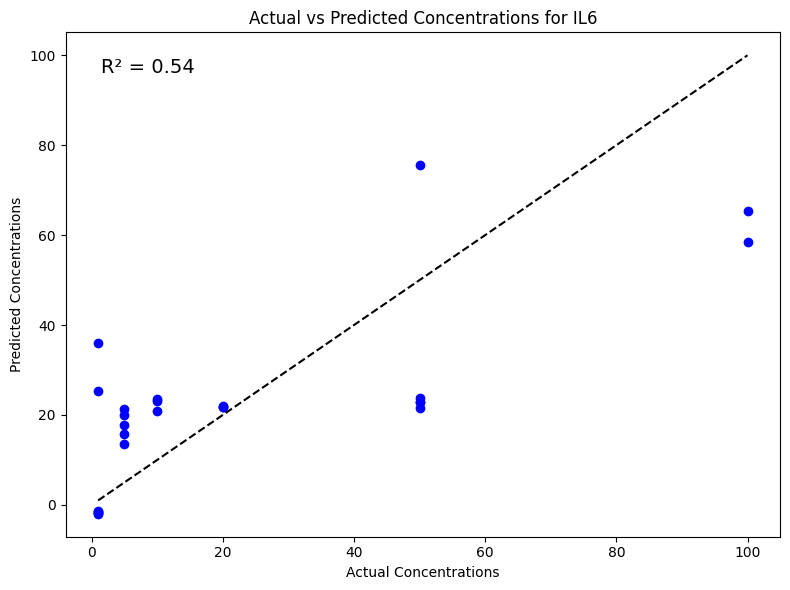

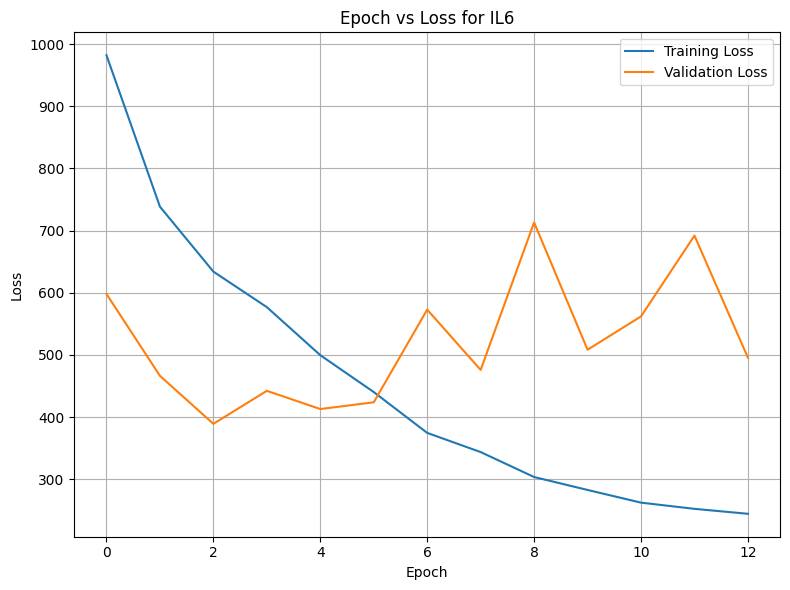

Original X shape: (1025, 81), Original y shape: (81,)
Original data size: 64, Augmented data size: 1344
Ridge Regression MSE: 1116.3456799202413, R2: 0.7963518361082287


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.105e+03, tolerance: 4.006e+02
  model = cd_fast.enet_coordinate_descent(


Lasso Regression MSE: 1737.5147021042535, R2: 0.6830357431546026


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.989e+05, tolerance: 4.006e+02
  model = cd_fast.enet_coordinate_descent(


ElasticNet Regression MSE: 1849.7688986185194, R2: 0.6625578916965222
XGBoost Regression MSE: 1138.3565458869105, R2: 0.7923365274807967
Epoch 1/200
42/42 [==============================] - 1s 7ms/step - loss: 3938.3181 - val_loss: 4022.2124
Epoch 2/200
42/42 [==============================] - 0s 3ms/step - loss: 2558.2629 - val_loss: 3184.8901
Epoch 3/200
42/42 [==============================] - 0s 3ms/step - loss: 2282.0371 - val_loss: 1998.9742
Epoch 4/200
42/42 [==============================] - 0s 3ms/step - loss: 1954.5714 - val_loss: 1429.5635
Epoch 5/200
42/42 [==============================] - 0s 3ms/step - loss: 1673.5463 - val_loss: 1501.3058
Epoch 6/200
42/42 [==============================] - 0s 3ms/step - loss: 1341.7404 - val_loss: 1122.5133
Epoch 7/200
42/42 [==============================] - 0s 3ms/step - loss: 1115.5890 - val_loss: 906.8930
Epoch 8/200
42/42 [==============================] - 0s 3ms/step - loss: 943.7060 - val_loss: 1375.2284
Epoch 9/200
42/42 [======

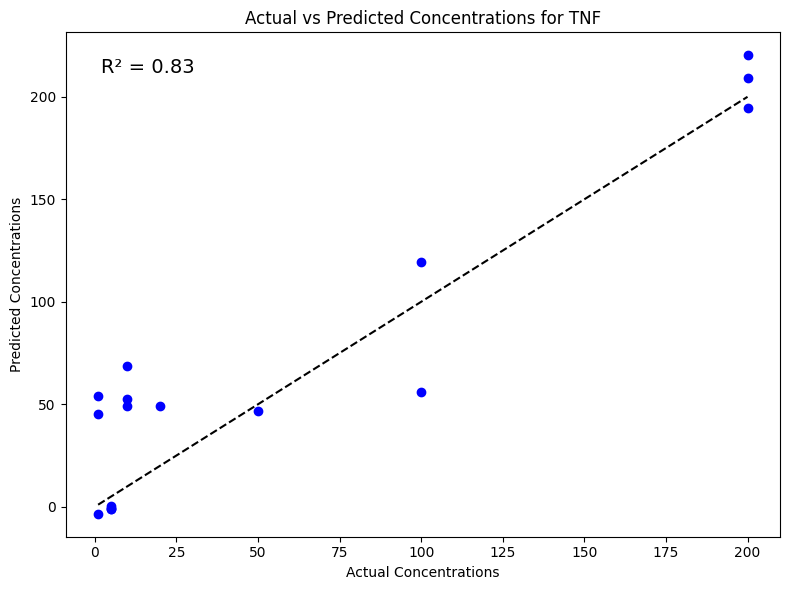

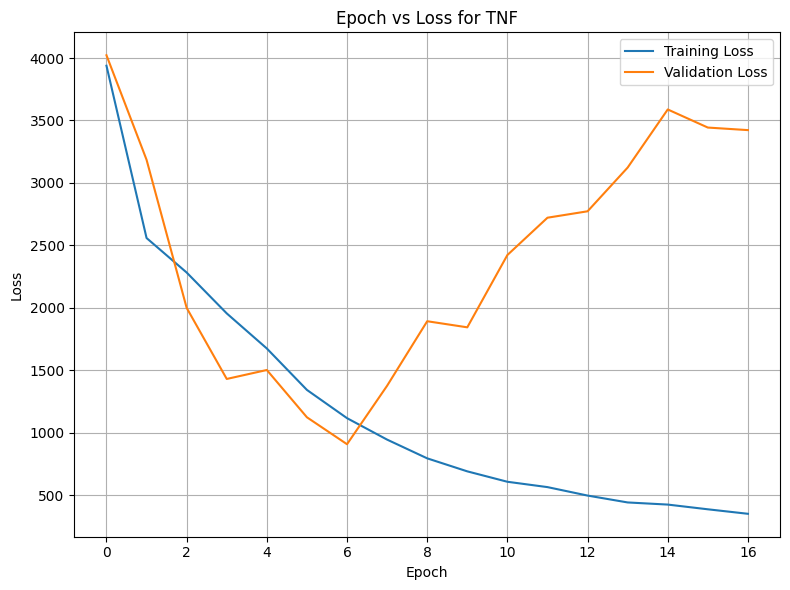

In [73]:
# Train and validate with increased epochs and batch size
results_regression = train_and_validate(data, materials, concentrations, material_types, display=display, figure_path=figure_path, epochs=epochs, batch_size=batch_size, num_augmented_samples=num_augmented_samples, use_early_stopping=use_early_stopping)

Original data size: 185, Augmented data size: 3885
Material Classification Report (Validation):
              precision    recall  f1-score   support

           0       1.00      0.29      0.44         7
           1       0.92      1.00      0.96        22
           2       0.86      1.00      0.92        18

    accuracy                           0.89        47
   macro avg       0.92      0.76      0.77        47
weighted avg       0.91      0.89      0.87        47

Confusion matrix saved/content/drive/My Drive/Colab Notebooks/Spectra/Low/Figures/CM_1.png


<Figure size 800x600 with 0 Axes>

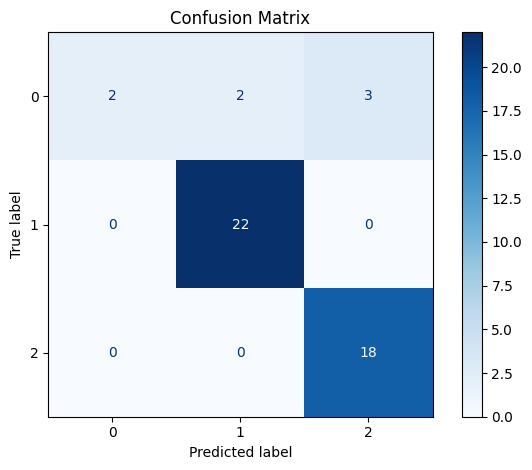

Material: 0
Specificity: 1.00
Sensitivity: 0.29

Material: 1
Specificity: 0.92
Sensitivity: 1.00

Material: 2
Specificity: 0.90
Sensitivity: 1.00



In [79]:
# Set parameters
validation_size = 0.2  # Adjust validation size if necessary

# Classify materials with data augmentation and class weighting
classify_materials(data, materials, display=display, figure_path=figure_path, validation_size=validation_size, num_augmented_samples=num_augmented_samples)